In [1]:
import torch, torchvision
from torchvision import datasets
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR100
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Cho 2 pretrained model trên 2 dataset CIFAR-10 và MNIST, finetune trên dataset mới FashionMNIST (có trong thư viện torchvision).

In [2]:
cifar_state_dict = torch.load("/content/drive/MyDrive/DL4: Finetuning/cifar10_mini_vgg.pth")
mnist_state_dict = torch.load("/content/drive/MyDrive/DL4: Finetuning/mnist_mini_vgg.pth")

class MiniVGG(nn.Module):
    def __init__(
        self,
    ):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256 * 3 * 3, 10)
        nn.init.normal_(self.classifier.weight, 0, 0.01)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(
        self,
        x,
    ):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
model_cifar = MiniVGG().to(device)
model_cifar.load_state_dict(cifar_state_dict, strict=False)
model_mnist = MiniVGG().to(device)
model_mnist.load_state_dict(mnist_state_dict, strict=False)

model_cifar.features.requires_grad = False
model_mnist.features.requires_grad = False

Data augmentation: normalize ảnh từ scale [0, 255] về [-1,1], sử dụng ít nhất 2 trong số các transformations dưới đây cho dataset
- Random resized
- Center cropping
- Random vertical flipping
- Random horizontal flipping
Các loại transformation khác có thể tham khảo ở đây


In [3]:
bs = 64
transform_train = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((28,28)),
    v2.ToTensor(),
])

transform_test = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((28,28)),
    v2.ToTensor(),
])

fashionMNIST_train = FashionMNIST(root = ".", train = True, download = True, transform=transform_train)
fashionMNIST_test = FashionMNIST(root = ".", train = False, download = True, transform=transform_test)
fashionMNIST_train_loader = DataLoader(fashionMNIST_train, batch_size = bs, shuffle = True)
fashionMNIST_test_loader = DataLoader(fashionMNIST_test, batch_size = 1, shuffle = True)




/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


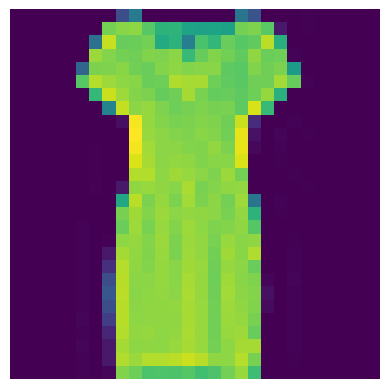

In [4]:
image = fashionMNIST_train[20][0]
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [5]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  losses = []
  for epoch in range(1, n_epochs + 1):
      loss_train = 0.0
      for imgs, labels in train_loader:
          imgs = imgs.to(device)
          labels = labels.to(device)
          outputs = model(imgs)
          loss = loss_fn(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss_train += loss.item()
      print ('Epoch [{}/{}], Loss: {:.4f}'
          .format(epoch, n_epochs, loss_train / len(train_loader)))
      losses.append(loss_train / len(train_loader))

  return losses

Fine-tuning: Cho mô hình MiniVGG như dưới, hãy load 2 pretrained models vào model MiniVGG ở dưới. Freeze self.features và train lớp cuối (self.classifier) của 2 pretrained models trên dataset FashionMNIST. Sau đó, train model MiniVGG from scratch trên tập FashionMNIST.

In [6]:
num_epochs = 5
learning_rate = 0.001

optimizer = torch.optim.SGD(model_cifar.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

losses_cifar = training_loop(
    n_epochs = num_epochs,
    optimizer = optimizer,
    model = model_cifar,
    loss_fn = loss_fn,
    train_loader = fashionMNIST_train_loader
)

Epoch [1/5], Loss: 1.0133
Epoch [2/5], Loss: 0.4957
Epoch [3/5], Loss: 0.4284
Epoch [4/5], Loss: 0.3865
Epoch [5/5], Loss: 0.3624


In [7]:
optimizer = torch.optim.SGD(model_mnist.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

losses_mnist = training_loop(
    n_epochs = num_epochs,
    optimizer = optimizer,
    model = model_mnist,
    loss_fn = loss_fn,
    train_loader = fashionMNIST_train_loader
)

Epoch [1/5], Loss: 1.0879
Epoch [2/5], Loss: 0.6331
Epoch [3/5], Loss: 0.5353
Epoch [4/5], Loss: 0.4849
Epoch [5/5], Loss: 0.4528


In [8]:
VGG = MiniVGG().to(device)
optimizer = torch.optim.SGD(VGG.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

losses_vgg = training_loop(
    n_epochs = num_epochs,
    optimizer = optimizer,
    model = VGG,
    loss_fn = loss_fn,
    train_loader = fashionMNIST_train_loader
)

Epoch [1/5], Loss: 2.3022
Epoch [2/5], Loss: 2.3013
Epoch [3/5], Loss: 2.3000
Epoch [4/5], Loss: 2.2978
Epoch [5/5], Loss: 2.2928


Với 3 models, train 5 epochs và báo cáo accuracy trên tập test của 3 models

In [9]:
from sklearn.metrics import classification_report
with torch.no_grad():
    predictions = []
    labels_l = []
    correct = 0
    total = 0
    for images, labels in fashionMNIST_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_cifar(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.append(predicted.item())
        labels_l.append(labels.item())
        del images, labels, outputs
report_cifar = classification_report(predictions, labels_l)
print("Classification report of fine tuned model from cifar")
print(report_cifar)

Classification report of fine tuned model from cifar
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1028
           1       0.96      0.98      0.97       975
           2       0.81      0.79      0.80      1023
           3       0.87      0.87      0.87      1008
           4       0.83      0.76      0.79      1088
           5       0.94      0.93      0.94      1010
           6       0.60      0.68      0.64       879
           7       0.91      0.92      0.92       988
           8       0.95      0.96      0.96       987
           9       0.95      0.93      0.94      1014

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.87      0.86      0.87     10000



In [10]:
with torch.no_grad():
    predictions = []
    labels_l = []
    correct = 0
    total = 0
    for images, labels in fashionMNIST_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_mnist(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.append(predicted.item())
        labels_l.append(labels.item())
        del images, labels, outputs
print("Classification report of fine tuned model from mnist")
report_mnist = classification_report(predictions, labels_l)
print(report_mnist)

Classification report of fine tuned model from mnist
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       923
           1       0.94      0.99      0.96       943
           2       0.71      0.77      0.74       929
           3       0.86      0.83      0.84      1043
           4       0.79      0.72      0.75      1102
           5       0.94      0.87      0.91      1077
           6       0.63      0.61      0.62      1041
           7       0.86      0.92      0.89       944
           8       0.93      0.93      0.93      1001
           9       0.92      0.93      0.93       997

    accuracy                           0.83     10000
   macro avg       0.83      0.84      0.84     10000
weighted avg       0.83      0.83      0.83     10000



In [11]:
with torch.no_grad():
    predictions = []
    labels_l = []
    correct = 0
    total = 0
    for images, labels in fashionMNIST_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = VGG(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.append(predicted.item())
        labels_l.append(labels.item())
        del images, labels, outputs

print("Classification report of model trained from scratch")
report_vgg = classification_report(predictions, labels_l)
print(report_vgg)

Classification report of model trained from scratch
              precision    recall  f1-score   support

           0       0.00      0.50      0.01         8
           1       0.00      0.00      0.00         0
           2       0.08      0.06      0.07      1269
           3       0.03      0.79      0.06        39
           4       0.98      0.13      0.23      7551
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.03      0.03      0.03      1133
           9       0.00      0.00      0.00         0

    accuracy                           0.11     10000
   macro avg       0.11      0.15      0.04     10000
weighted avg       0.75      0.11      0.19     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###  - Mô hình nào có accuracy cao nhất và tại sao?

Model cifar có kết quả cao nhất do dataset này gồm nhiều ảnh với chủ đề khác nhau nên có thể có nhiều feature tổng quát cho hình ảnh về thời trang, ngược lại dataset mnist chỉ là hình ảnh của những con số nên có thể không tốt bằng, model mini_VGG có kết quả tệ nhất vì số epoch chưa đủ để mô hình có thể học một cách hiệu quả.

### - Nếu train với nhiều epochs hơn thì accuracy của 3 models có giống nhau không?


Nếu tăng số epochs lên đủ lớn thì model train từ đầu sẽ có kết quả tốt nhất so với 2 model finetune bởi những feature tạo ra ở model này fit với data hơn.

# Feature extractor: Với model tương tự như homework 2, dùng get_graph_node_names() và create_feature_extractor từ thư viện torchvision.models.feature_extraction để in ra tên layer và weight của layer tương ứng


In [12]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import torch.nn.functional as F



In [13]:
train_nodes, eval_nodes = get_graph_node_names(model_mnist)

In [14]:
create_feature_extractor(model_mnist, train_return_nodes = train_nodes, eval_return_nodes = eval_nodes)

MiniVGG(
  (features): Module(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=2304, out_features=10, bias=True)
)

In [15]:
model_mnist.features[5]

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [16]:
model_mnist.features[5].weight

Parameter containing:
tensor([[[[-4.2842e-03, -2.1994e-02, -7.9081e-03],
          [-3.1881e-02, -5.1875e-02, -2.2890e-02],
          [-5.5099e-02, -4.3180e-02,  1.8146e-02]],

         [[-9.0254e-03, -2.0297e-02, -2.3061e-02],
          [ 5.2245e-02,  5.2892e-02,  4.6602e-02],
          [ 1.5797e-03,  6.0276e-03, -6.3113e-03]],

         [[-6.7427e-03, -3.4601e-03,  6.8334e-03],
          [ 1.3255e-02,  3.7185e-02,  3.5690e-02],
          [-1.6746e-02, -1.5730e-03,  1.3263e-02]],

         ...,

         [[-1.1260e-02, -2.1871e-03, -1.1764e-02],
          [-3.1190e-03, -5.6492e-03, -2.2009e-03],
          [-1.3913e-02, -5.1290e-03,  3.4202e-03]],

         [[-3.8904e-02, -3.9683e-02, -8.1803e-03],
          [ 1.1483e-03,  3.3098e-03,  2.6540e-02],
          [-3.1523e-02, -3.2937e-02,  8.1226e-03]],

         [[-1.0552e-02,  1.1497e-02,  3.0405e-02],
          [ 1.1333e-02,  4.5189e-02,  6.6236e-02],
          [-2.5928e-02, -2.4763e-02, -1.0354e-02]]],


        [[[-1.0260e-02, -2.3268